In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time


In [16]:
data_dir = './RAFDB'
batch_size = 64
num_classes = 7

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Loaded pretrained weights for efficientnet-b0


In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=7):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct.double() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [19]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50 | Train Loss: 1.5152, Acc: 0.4432 | Val Loss: 1.3394, Acc: 0.4791
Epoch 2/50 | Train Loss: 1.1804, Acc: 0.5709 | Val Loss: 0.9128, Acc: 0.6819
Epoch 3/50 | Train Loss: 1.0205, Acc: 0.6359 | Val Loss: 0.7811, Acc: 0.7184
Epoch 4/50 | Train Loss: 0.9324, Acc: 0.6651 | Val Loss: 0.7102, Acc: 0.7428
Epoch 5/50 | Train Loss: 0.8607, Acc: 0.6935 | Val Loss: 0.6556, Acc: 0.7562
Epoch 6/50 | Train Loss: 0.8113, Acc: 0.7050 | Val Loss: 0.6203, Acc: 0.7683
Epoch 7/50 | Train Loss: 0.7641, Acc: 0.7261 | Val Loss: 0.6211, Acc: 0.7774
Epoch 8/50 | Train Loss: 0.7214, Acc: 0.7435 | Val Loss: 0.5963, Acc: 0.7849
Epoch 9/50 | Train Loss: 0.6996, Acc: 0.7497 | Val Loss: 0.6114, Acc: 0.7878
Epoch 10/50 | Train Loss: 0.6680, Acc: 0.7627 | Val Loss: 0.5723, Acc: 0.8035
Epoch 11/50 | Train Loss: 0.6394, Acc: 0.7710 | Val Loss: 0.5512, Acc: 0.8077
Epoch 12/50 | Train Loss: 0.6101, Acc: 0.7837 | Val Loss: 0.5732, Acc: 0.8070
Epoch 13/50 | Train Loss: 0.6083, Acc: 0.7791 | Val Loss: 0.5633, Acc: 0.

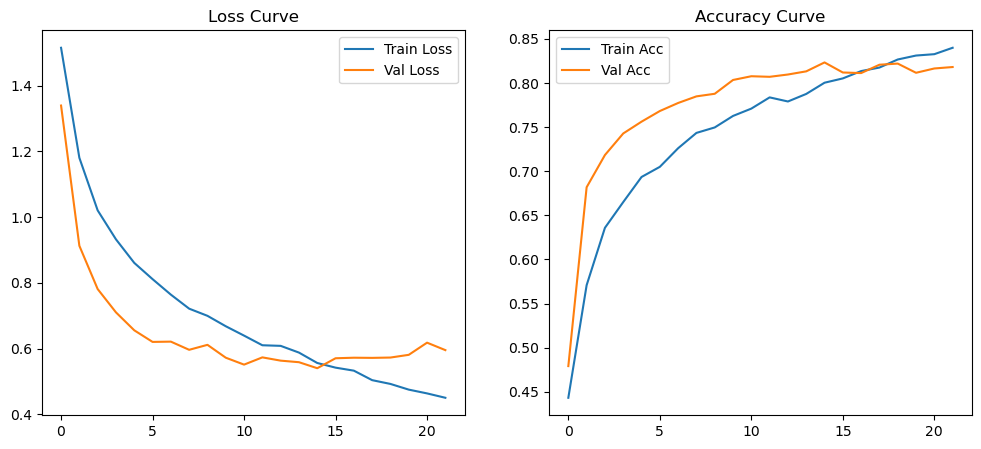

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


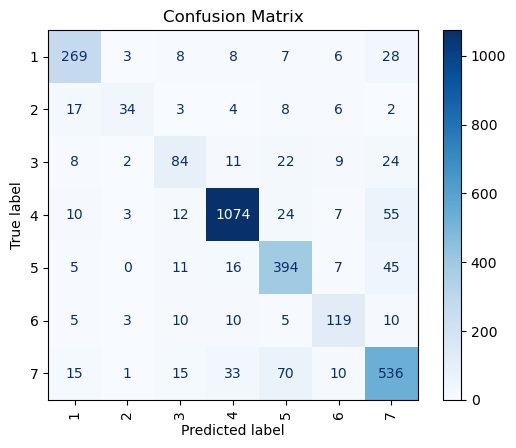

In [21]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')  
plt.title("Confusion Matrix")
plt.show()


Correct Predictions:


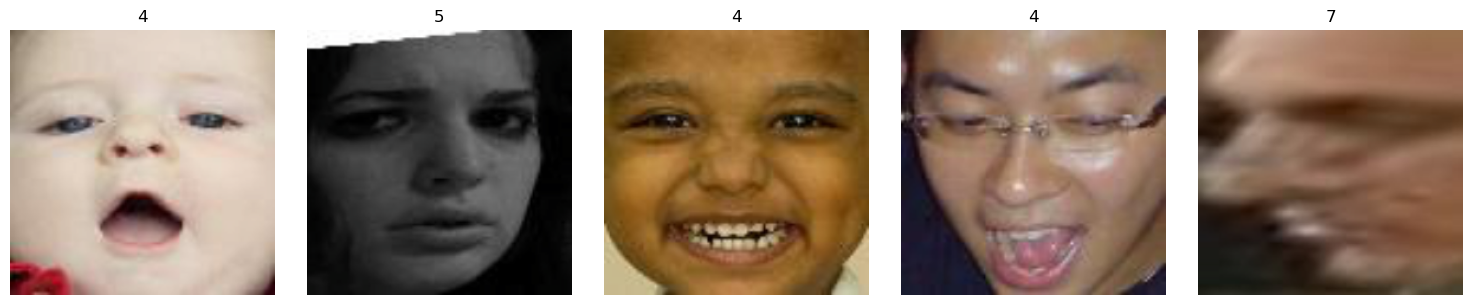

Incorrect Predictions:


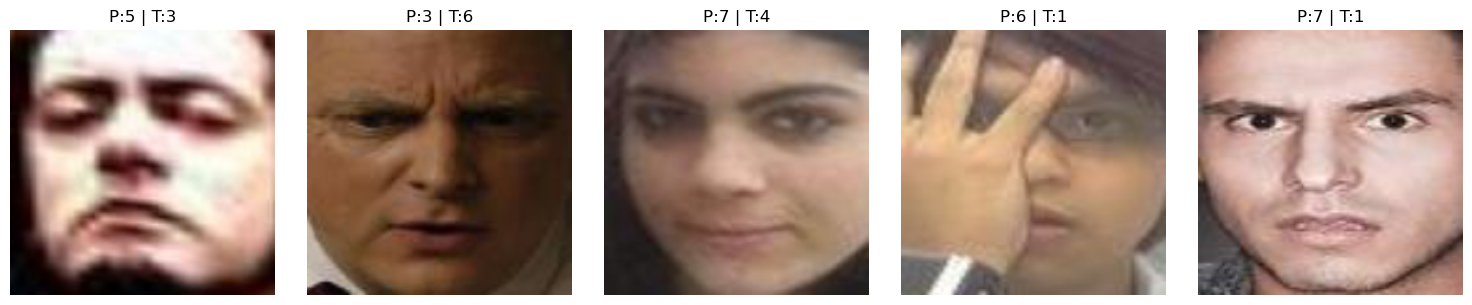

In [31]:
import random
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

correct, incorrect = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(inputs.size(0)):
            if preds[i].cpu() == labels[i]:
                correct.append((inputs[i].cpu(), preds[i].item()))
            else:
                incorrect.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))

# Show 5 correct
print("Correct Predictions:")
correct_samples = random.sample(correct, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    inp = correct_samples[i][0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.set_title(f'{class_names[correct_samples[i][1]]}')
plt.tight_layout()
plt.show()

# Show 5 incorrect
print("Incorrect Predictions:")
incorrect_samples = random.sample(incorrect, 5)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axarr[i]
    ax.axis('off')
    inp = incorrect_samples[i][0].numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    pred, true = class_names[incorrect_samples[i][1]], class_names[incorrect_samples[i][2]]
    ax.imshow(inp)
    ax.set_title(f'P:{pred} | T:{true}')
plt.tight_layout()
plt.show()

